## Time-Series Decomposition

Extract the seasonal patterns from the time-series

In [208]:
from data_exploitation.exports_analytics.data.scripts import time_series_generator
from data_exploitation.exports_analytics.exploratory_data_analysis.scripts import time_granularities_analysis, time_granularities_generator
from database_settings import postgres_utilities
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import linear_model



### Get available headings

In [209]:
# Get available headings from peru_exports_sandbox
engine = postgres_utilities.engine()
available_headings = postgres_utilities.run_query_file(engine,
                                                       './../data/queries/read_available_headings.sql')
available_headings = pd.DataFrame(available_headings)
available_headings

Connected to Formatted Zone successfully!


,heading,description
0,0712909000,Otras hortalizas y mezclas de hortalizas corta...
1,0805291000,Tangelo (Citrus reticulata x Citrus paradisis)...
2,0810400000,"Arándanos rojos, mirtilos y demas frutos del g..."
3,0713359000,"Frijoles (fréjoles, porotos, alubias, judías) ..."
4,0805502100,"Limón (limón sutil, limón común, limón criollo..."
5,0810901000,"Granadilla, maracuya (parchita) y demas frutas..."
6,0702000000,Tomates frescos o refrigerados
7,0709999000,Otras hortalizas frescas o refrigeradas
8,0801220000,Nueces del Brasil sin cáscara
9,0710400000,"Maiz dulce incluso cocidos, congelados"


### Build a time-series

In [210]:
# Choose a heading
chosen_heading = '0810400000'
# Choose the observed measure (usd_kg or net_weight)
observation = 'usd_kg'

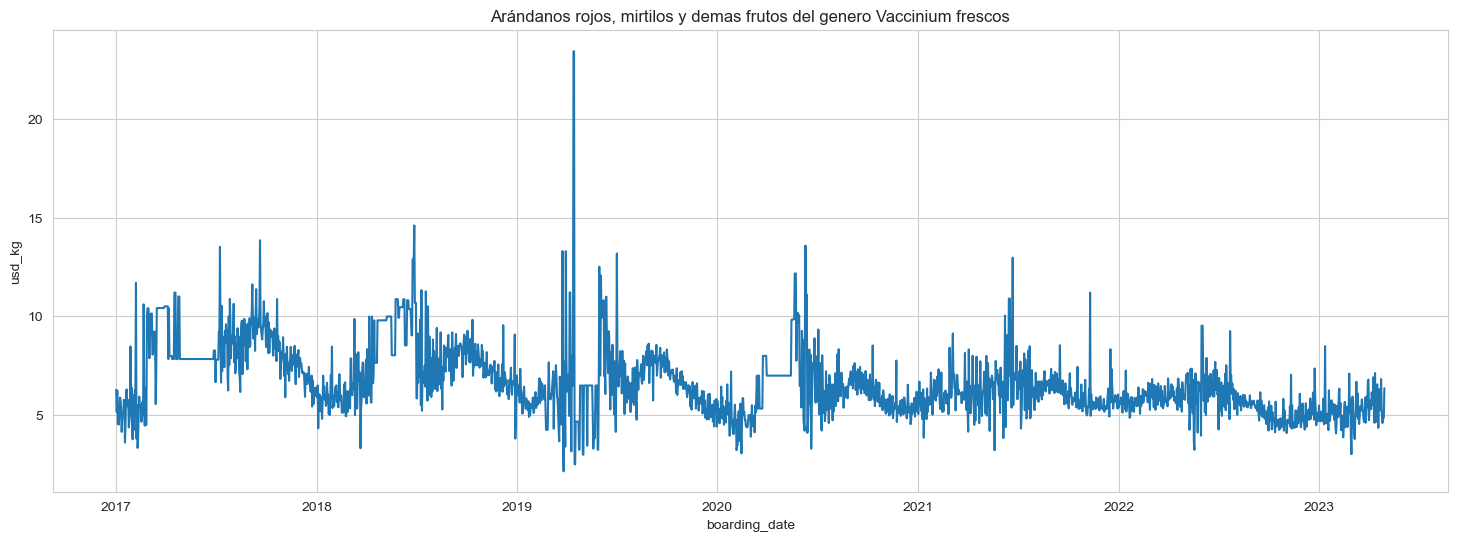

In [211]:
# Get a time-series
ts = time_series_generator.generate(chosen_heading, observation)
ts.plot()

In [212]:
# Add the time granularities
time_granularities, priority = time_granularities_generator.generate(ts.start_date, ts.end_date)
data = pd.concat([ts.data, time_granularities], axis=1)
data

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-01,6.280,2017,1,1,1,1,1,1,1,1,1,1,7,52,26,13,5
2017-01-02,5.144,2017,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1
2017-01-03,6.243,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,4.551,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,4.590,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26,4.610,2023,1,2,4,4,1,2,116,116,26,26,3,17,17,4,4
2023-04-27,4.610,2023,1,2,4,4,1,2,117,117,27,27,4,17,17,4,4
2023-04-28,4.874,2023,1,2,4,4,1,2,118,118,28,28,5,17,17,4,4
2023-04-29,4.874,2023,1,2,4,4,1,2,119,119,29,29,6,17,17,4,4


### Get a list of the seasonal patterns to extract

In [213]:
# Get a list of seasonal patterns in order of extraction

# Define the granularities to analyze
granularities = ['semester_in_year',
                 'quarter_in_year',
                 'month_in_year',
                 'month_in_semester',
                 'month_in_quarter',
                 'quarter_in_semester',
                 'day_in_month',
                 'day_in_week',
                 'week_in_year',
                 'week_in_semester',
                 'week_in_quarter',
                 'week_in_month']

selected_granularities = []
for g in tqdm(granularities):
    print('Analyzing {}...'.format(g))
    seasonality_analysis = time_granularities_analysis.analysis(cyclic_granularity=g,
                                    observations=observation,
                                    data=data)
    # seasonality_analysis.plot()
    if seasonality_analysis.is_seasonal(): selected_granularities.append(g)
selected_granularities = [x for x in priority if x in selected_granularities]
selected_granularities

  0%|          | 0/12 [00:00<?, ?it/s]

Analyzing semester_in_year...
Analyzing quarter_in_year...
Analyzing month_in_year...


C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Analyzing month_in_semester...
Analyzing month_in_quarter...
Analyzing quarter_in_semester...
Analyzing day_in_month...
Analyzing day_in_week...
Analyzing week_in_year...
Analyzing week_in_semester...
Analyzing week_in_quarter...
Analyzing week_in_month...


['semester_in_year',
 'month_in_quarter',
 'quarter_in_year',
 'month_in_semester',
 'month_in_year',
 'week_in_quarter',
 'week_in_semester',
 'week_in_year']

### Make the extraction of seasonal patterns

In [214]:
# # Approach 1: Get the seasonal patterns in an additive way, first removing the lower level time granularities
#
# time_series = data[observation].values
# seasonal_patterns = {}
#
# # Plot time-series
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=time_series)
# plt.title('Original time-series')
# plt.show()
#
# # Initialize the residuals
# residuals = time_series
#
# for i in tqdm(range(20)):
#
#     # Get the pattern for every granularity
#     for granularity in selected_granularities:
#
#         # Refine the pattern (if already extracted before)
#         if granularity in seasonal_patterns:
#             residuals = residuals+seasonal_patterns[granularity]
#
#         # Get the label of every observation
#         labels = data[granularity].values
#         # Generate the pattern
#         pattern = []
#         for label in labels:
#             metric = np.mean(residuals[np.where(labels == label)])
#             pattern.append(metric)
#         seasonal_patterns[granularity] = pattern
#
#         # Remove the pattern from the time-series
#         residuals = residuals-pattern
#
#
# # Plot the seasonal patterns
# for key, value in seasonal_patterns.items():
#     # Plot pattern
#     plt.figure(figsize=(18, 6))
#     sns.lineplot(x=data.index, y=value)
#     plt.title(key)
#     plt.show()
#
# # Plot residuals
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=residuals)
# plt.title('Deseasonalized time-series')
# plt.show()

In [ ]:
# #Approach 2: Get the seasonal patterns. Each pattern is extracted directly from the original series. Then a linear regression is applied to get the exact contribution of each pattern to the original series
#
# time_series = data[observation].values
# seasonal_patterns = {}
#
# # Get the pattern for every granularity
# for granularity in tqdm(selected_granularities):
#
#     # Get the label of every observation
#     labels = data[granularity].values
#     # Generate the pattern
#     pattern = []
#     for label in labels:
#         filtered_indexes = np.where(labels == label)[0]
#         metric = np.median(time_series[filtered_indexes])
#         pattern.append(metric)
#     seasonal_patterns[granularity] = pattern
#
# # Convert dictionary to a 2D array
# X_array = np.column_stack([series for series in seasonal_patterns.values()])
#
# # Make the linear regression to get the contribution of each pattern to the time-series
# regr = linear_model.LinearRegression()
# regr.fit(X_array, time_series)
# coefficients = regr.coef_
# # print(coefficients)
#
# balanced_seasonal_patterns = {}
# # Multiply each coefficient with the corresponding pattern
# for index, (key, pattern) in enumerate(seasonal_patterns.items()):
#     coef = coefficients[index]
#     new_pattern = [value * coef for value in pattern]
#     balanced_seasonal_patterns[key] = new_pattern
#
# # Plot the seasonal patterns
# for key, pattern in balanced_seasonal_patterns.items():
#     # Plot pattern
#     plt.figure(figsize=(18, 6))
#     sns.lineplot(x=data.index, y=pattern)
#     plt.title(key)
#     plt.show()
#
# # Get the residuals
# residuals =  time_series
# for key, pattern in balanced_seasonal_patterns.items():
#     residuals = residuals - pattern
#
# # Plot original time-series
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=time_series)
# plt.title('Original time-series')
# plt.show()
#
# # Plot residuals
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=residuals)
# plt.title('Deseasonalized time-series')
# plt.show()


In [ ]:
# #Approach 3: Get the seasonal patterns. Each pattern is extracted directly from the original series. But now the average/median is taking only a specific amount of the labels. Then a linear regression is applied to get the exact contribution of each pattern to the original series
#
# time_series = data[observation].values
# seasonal_patterns = {}
#
# # Get the pattern for every granularity
# for granularity in tqdm(selected_granularities):
#
#     # Get the label of every observation
#     labels = data[granularity].values
#     # Generate the pattern
#     pattern = []
#     for index, label in enumerate(labels):
#
#         filtered_indexes = np.where(labels == label)[0]
#         num_closest = int(len(filtered_indexes) * 1)
#         tuples_array = [(filtered_indexes[i], abs_diff) for i, abs_diff in enumerate(np.abs(filtered_indexes - index))]
#         sorted_array = sorted(tuples_array, key=lambda x: x[1])
#         closest_indices = [t[0] for t in sorted_array[:num_closest]]
#
#         metric = np.mean(time_series[closest_indices])
#         pattern.append(metric)
#
#     seasonal_patterns[granularity] = pattern
#
# # Convert dictionary to a 2D array
# X_array = np.column_stack([series for series in seasonal_patterns.values()])
#
# # Make the linear regression to get the contribution of each pattern to the time-series
# regr = linear_model.LinearRegression()
# regr.fit(X_array, time_series)
# coefficients = regr.coef_
# print(coefficients)
#
# balanced_seasonal_patterns = {}
# # Multiply each coefficient with the corresponding pattern
# for index, (key, pattern) in enumerate(seasonal_patterns.items()):
#     coef = coefficients[index]
#     new_pattern = [value * coef for value in pattern]
#     balanced_seasonal_patterns[key] = new_pattern
#
# # Plot the seasonal patterns
# for key, pattern in balanced_seasonal_patterns.items():
#     # Plot pattern
#     plt.figure(figsize=(18, 6))
#     sns.lineplot(x=data.index, y=pattern)
#     plt.title(key)
#     plt.show()
#
# # Get the residuals
# residuals =  time_series
# for key, pattern in balanced_seasonal_patterns.items():
#     residuals = residuals - pattern
#
# # Plot original time-series
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=time_series)
# plt.title('Original time-series')
# plt.show()
#
# # Plot residuals
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=residuals)
# plt.title('Deseasonalized time-series')
# plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]

[ 0.39400169 -0.89569757 -0.25688615  0.75785541 -0.2882158   0.7508191
  0.16472081  1.07054466]


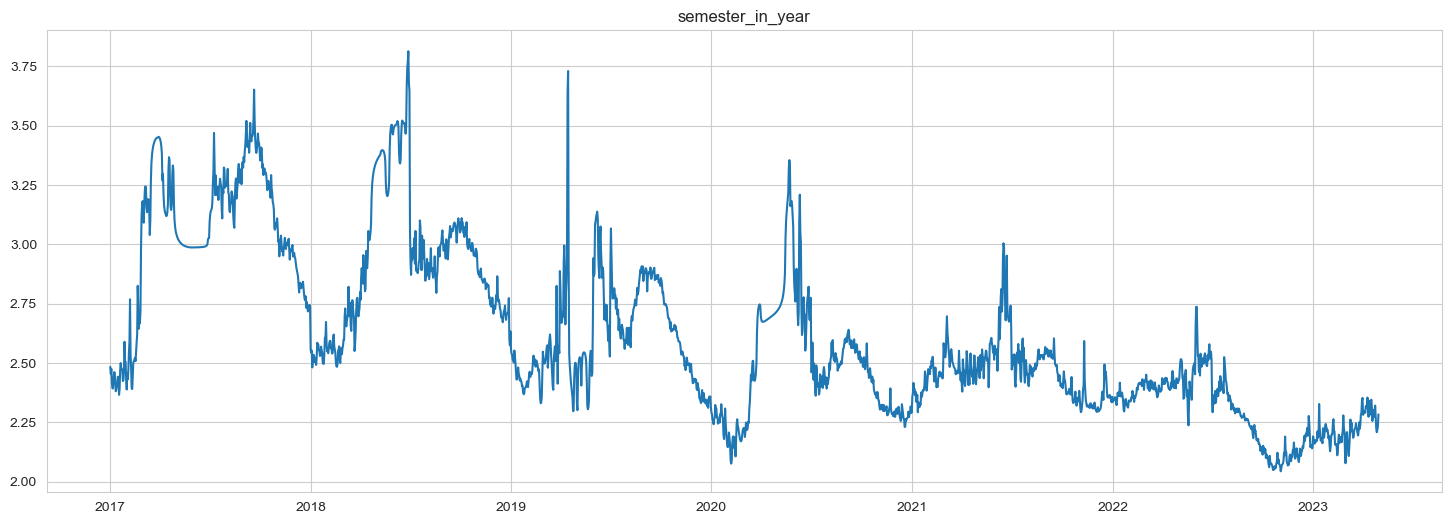

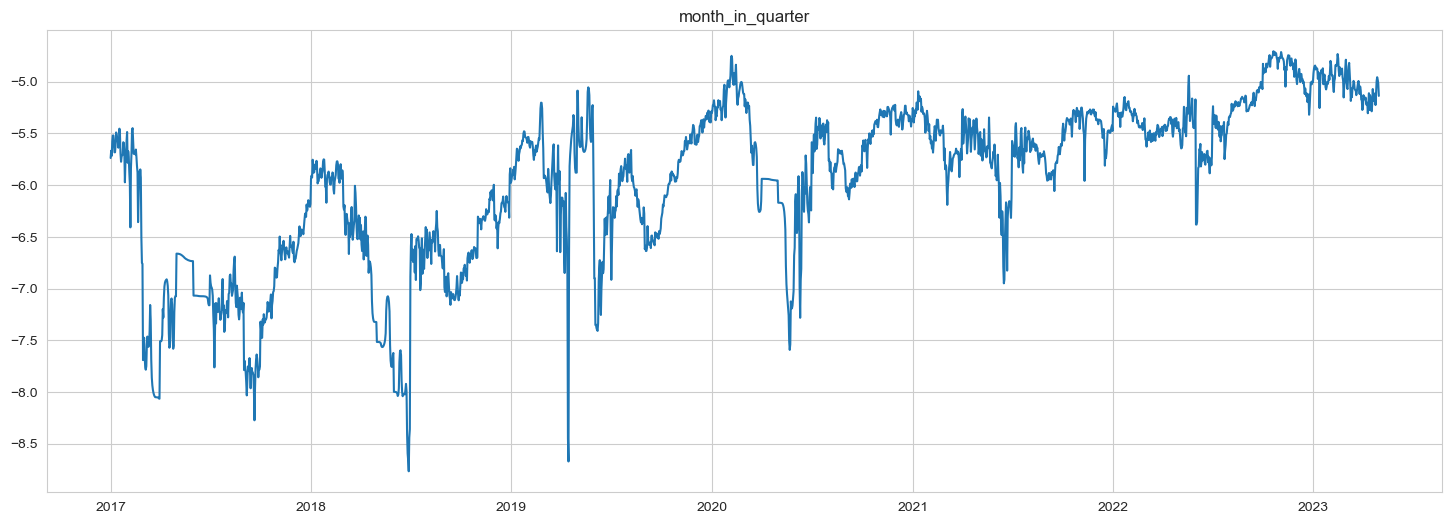

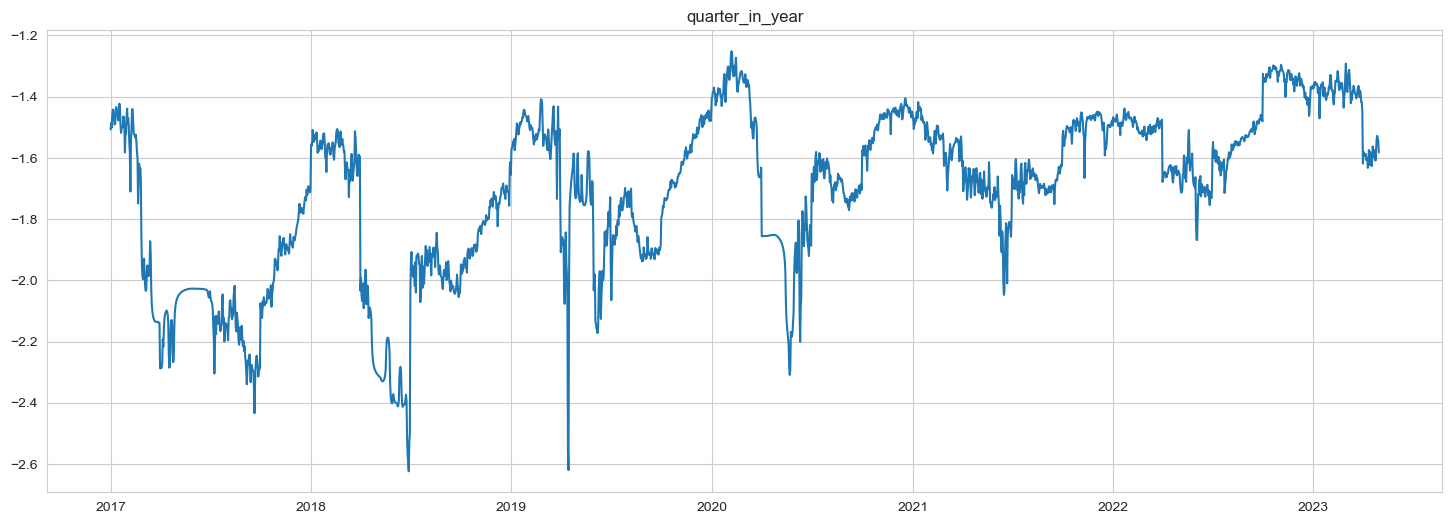

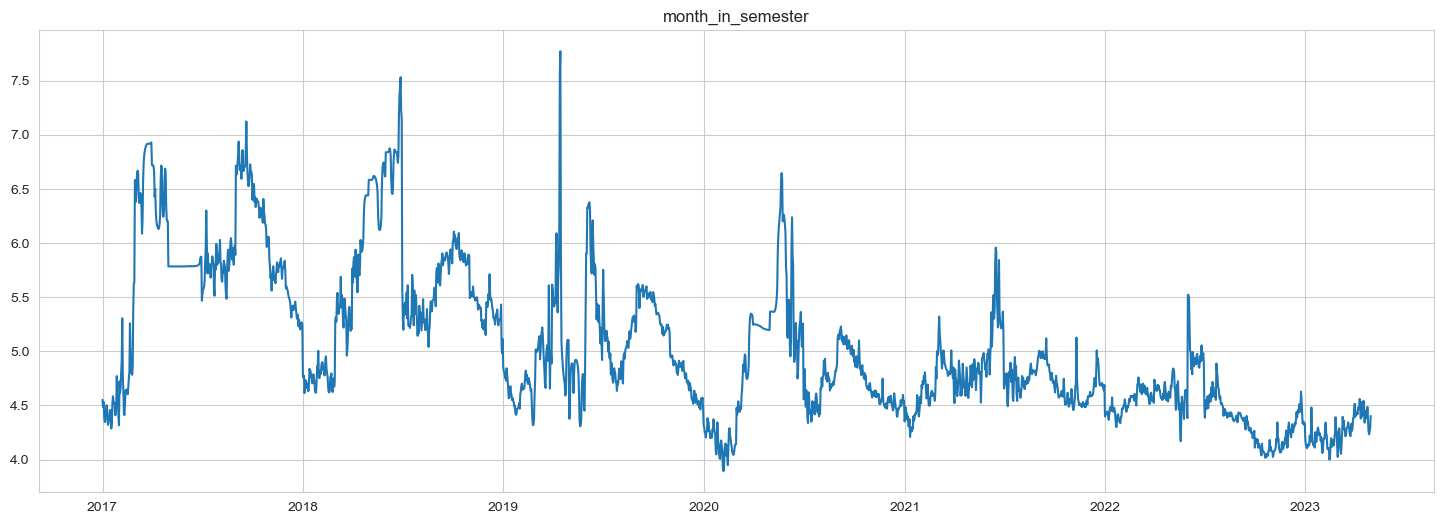

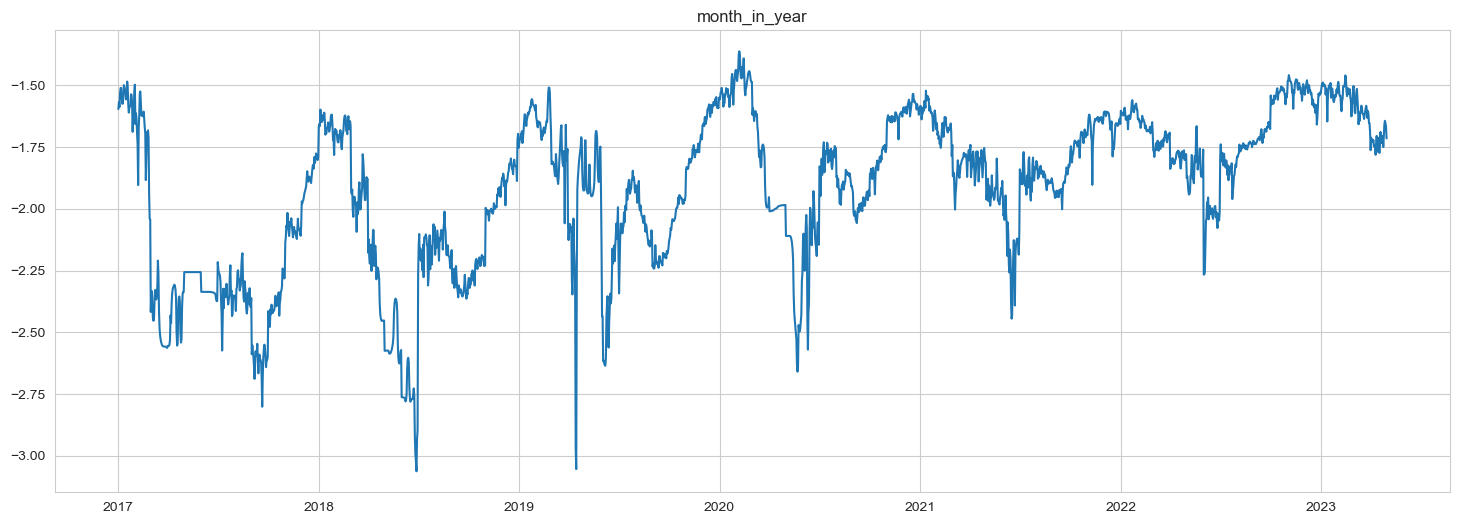

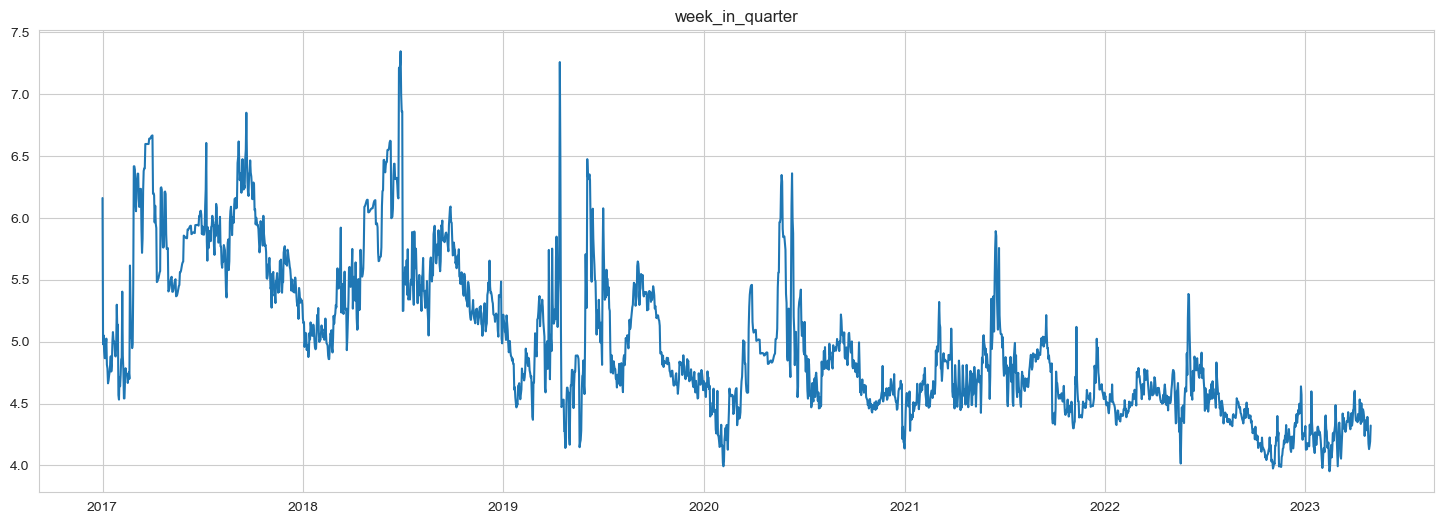

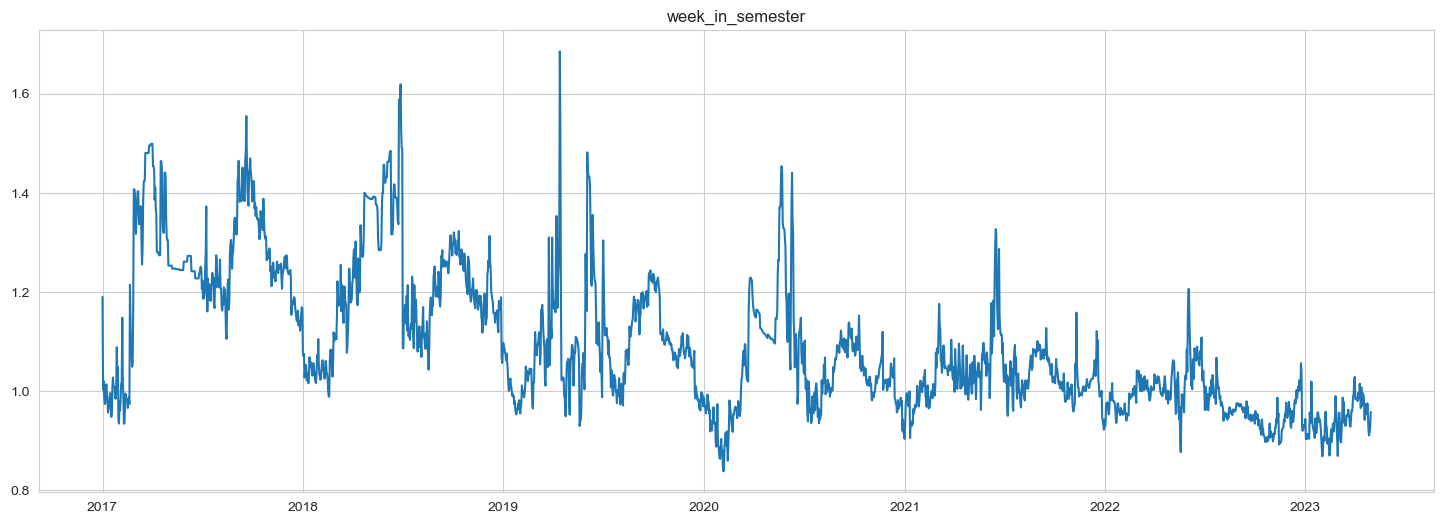

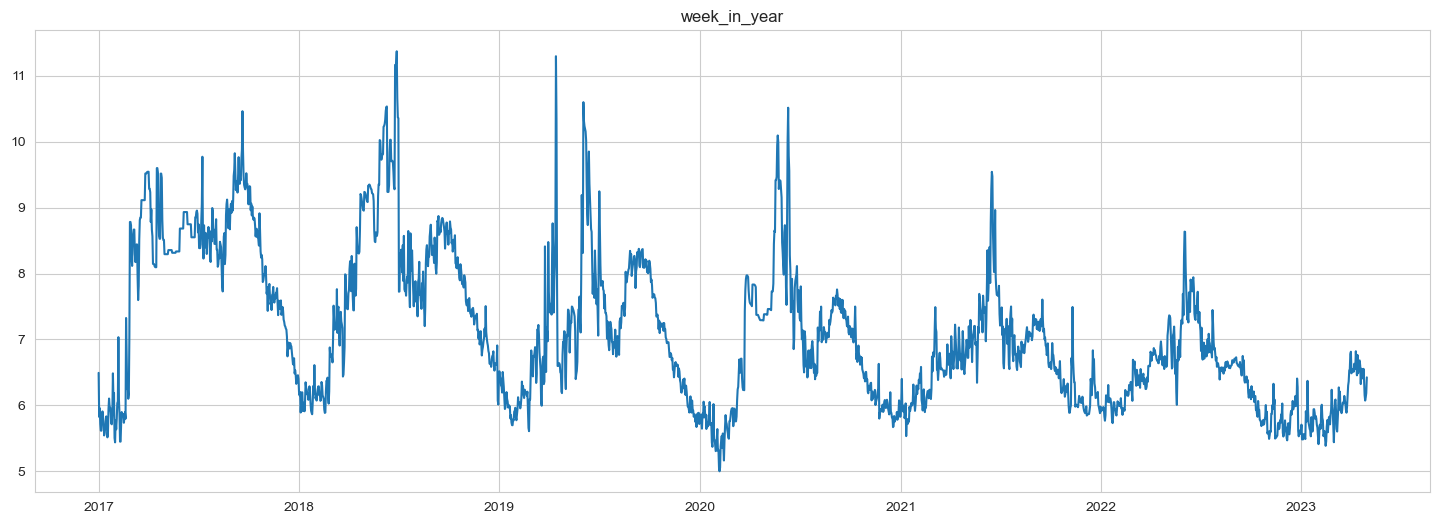

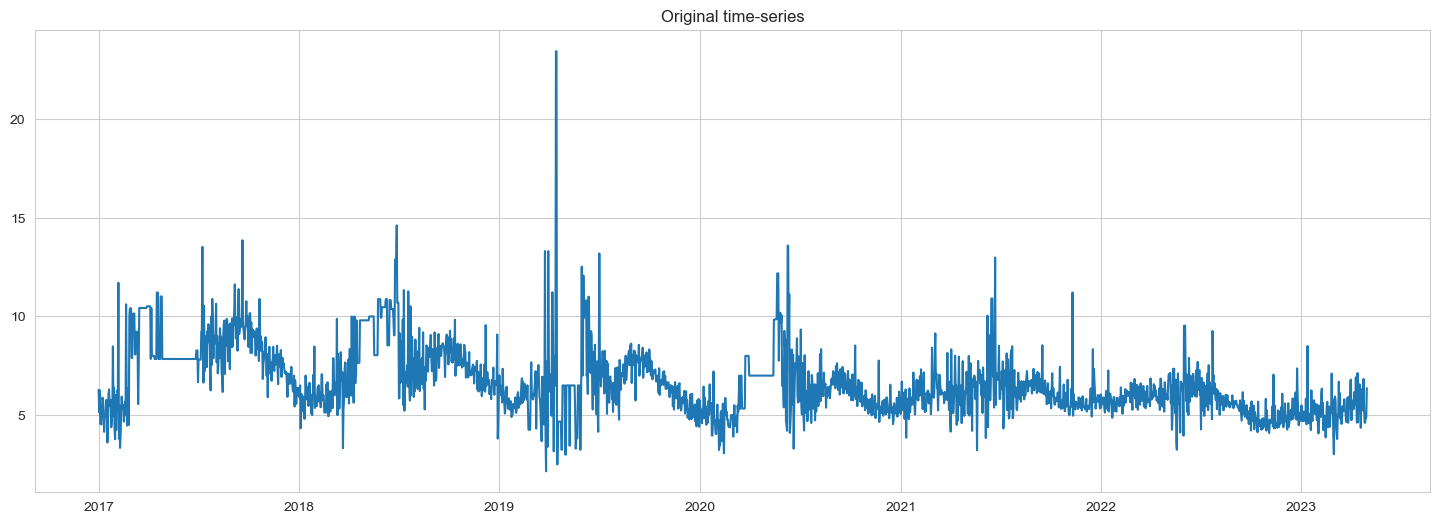

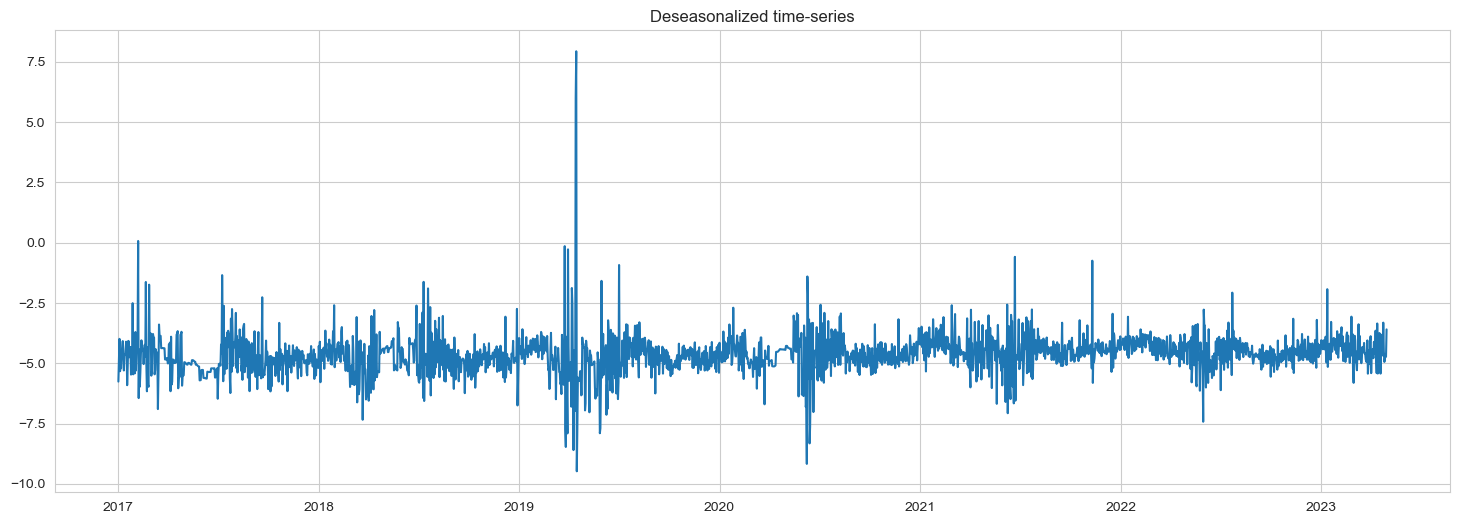

In [295]:
#Approach 4: Get the seasonal patterns. Each pattern is extracted directly from the original series. But now the average is taken only a specific amount of the observations from the same label. Those observations closer receive more weight in the average. Then a linear regression is applied to get the exact contribution of each pattern to the original series

time_series = data[observation].values
seasonal_patterns = {}

# Get the pattern for every granularity
for granularity in tqdm(selected_granularities):

    # Get the label of every observation
    labels = data[granularity].values
    # Generate the pattern
    pattern = []
    for index, label in enumerate(labels):

        filtered_indexes = np.where(labels == label)[0]
        num_closest = int(len(filtered_indexes) * 0.99)
        tuples_array = [(filtered_indexes[i], abs_diff) for i, abs_diff in enumerate(np.abs(filtered_indexes - index))]
        sorted_array = sorted(tuples_array, key=lambda x: x[1])
        closest_indices = [t[0] for t in sorted_array[:num_closest]]
        values = time_series[closest_indices]
        weights = 1 / np.arange(1, len(values) + 1) # Linear decay in weights
        #weights = np.power(0.1, len(values) - np.arange(len(values))) # Exponential decay in weights


        metric = np.average(values, weights=weights)
        pattern.append(metric)

    seasonal_patterns[granularity] = pattern

# Convert dictionary to a 2D array
X_array = np.column_stack([series for series in seasonal_patterns.values()])

# Make the linear regression to get the contribution of each pattern to the time-series
regr = linear_model.LinearRegression()
regr.fit(X_array, time_series)
coefficients = regr.coef_
print(coefficients)

balanced_seasonal_patterns = {}
# Multiply each coefficient with the corresponding pattern
for index, (key, pattern) in enumerate(seasonal_patterns.items()):
    coef = coefficients[index]
    new_pattern = [value * coef for value in pattern]
    balanced_seasonal_patterns[key] = new_pattern

# Plot the seasonal patterns
for key, pattern in balanced_seasonal_patterns.items():
    # Plot pattern
    plt.figure(figsize=(18, 6))
    sns.lineplot(x=data.index, y=pattern)
    plt.title(key)
    plt.show()

# Get the residuals
residuals =  time_series
for key, pattern in balanced_seasonal_patterns.items():
    residuals = residuals - pattern

# Plot original time-series
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=time_series)
plt.title('Original time-series')
plt.show()

# Plot residuals
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=residuals)
plt.title('Deseasonalized time-series')
plt.show()


### Extract the trend

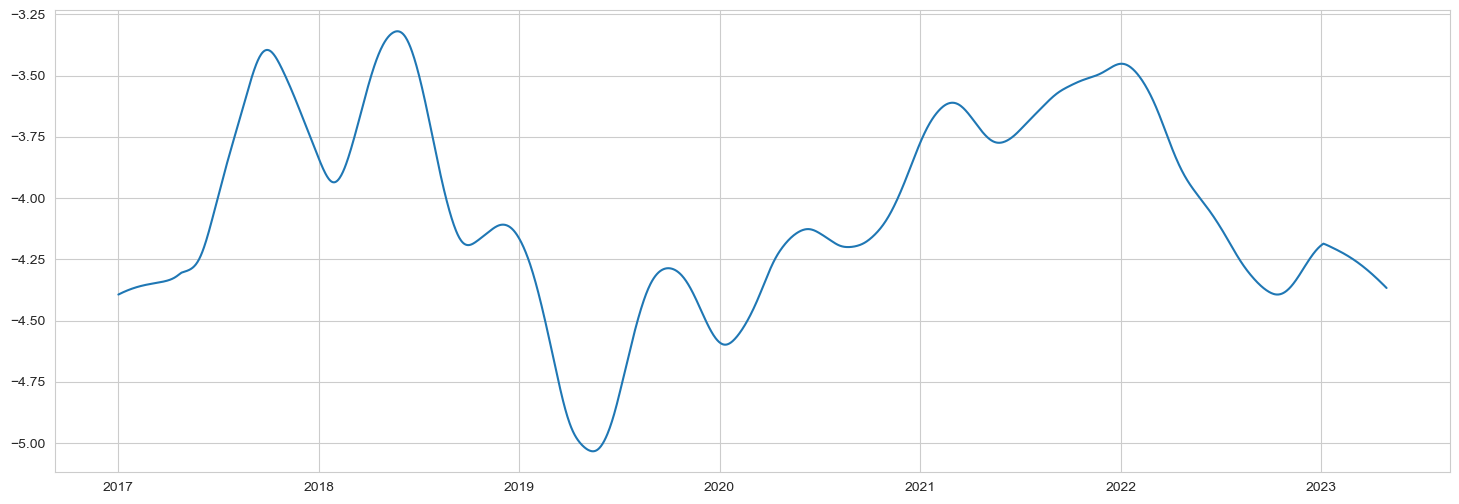

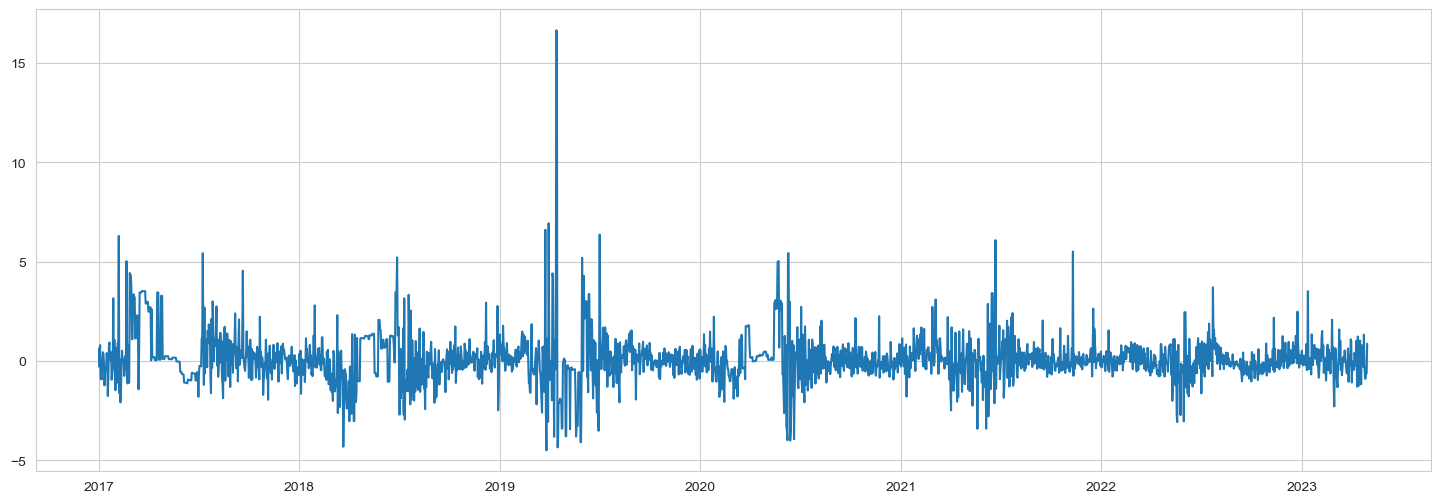

In [284]:
lowess = sm.nonparametric.lowess(residuals, data.index, frac=0.10)

# Extract the trend component
trend = lowess[:, 1]

# Plot trend
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=trend)
plt.show()


# Plot residuals
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=residuals-trend)
plt.show()

In [230]:
np.mean(residuals-trend)

0.12375046813524815

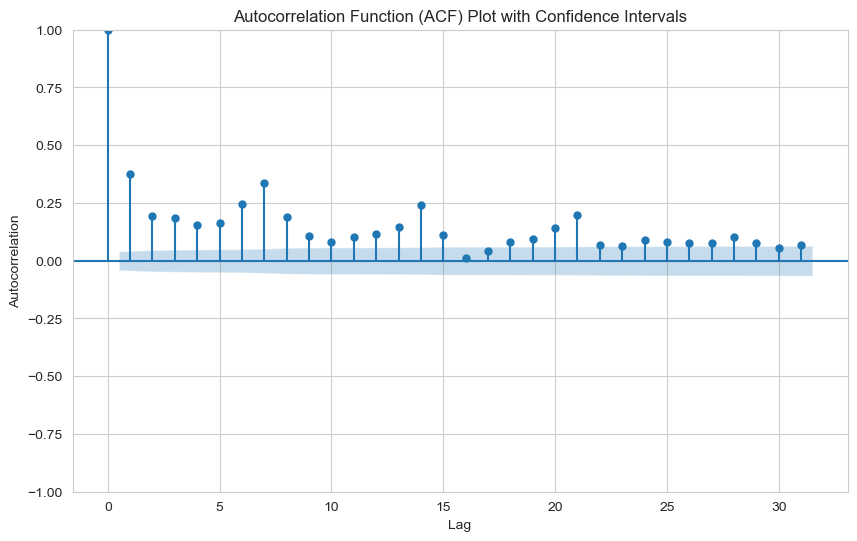

In [232]:
# Plot ACF with confidence intervals
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(residuals-trend, lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
plt.xlabel('Lag')

plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot with Confidence Intervals')
plt.show()